# CS 109A/AC 209A/STAT 121A Data Science: Homework 6
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, November 2nd, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW6.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
# Clear namespace
for name in dir():
    if not name.startswith('_'):
        del globals()[name]

In [2]:
# Data manipulation
import numpy as np
import pandas as pd

# Ploting
import matplotlib
import matplotlib.pyplot as plt

# Scientific computing
import scipy as sp
from scipy.stats import mode

# Machine Learning
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn import discriminant_analysis
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix
%matplotlib inline


## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Hagmann, Tim]

### Part (b): Course Number

[CS 109a]

### Part (c): Who did you work with?

[-]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Recommender System for Movies

In this problem, you will build a model to recommend movies using ratings from users. 

The dataset for this problem is contained in `dataset_4_ratings.txt`. This dataset contains ratings from 100 users for 1000 movies. The first two columns contain the user and movie IDs. The last column contains a 1 if the user liked the movie, and 0 otherwise. Not every movie is rated by every user (i.e. some movies have more ratings than others).

The names of the movies corresponding to the IDs are provided in `dataset_4_movie_names.txt`.

### Part 1(a): Exploring how to rank

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?


- **Implementation:** Suppose we measure the "goodness" of a movie by the probability that it will be liked by a user, $P(\textbf{label} = \text{like}|\textbf{movie}) = \theta_{\text{movie}}$. Assuming that each user independently rates a given movie according to the probability $\theta_{\text{movies}}$. Use a reasonable estimate of $\theta_{\text{movies}}$ to build a list of top 25 movies that you would recommend to a new user.

   **Hint:** What does the likelihood function, $P(\textbf{likes} = k | \theta_{\text{movie}}, n, \textbf{movie})$, look like? What $\theta_{\text{movie}}$ will maximize the likelihood?
   

- **Analysis:** Why is using $\theta_{\text{movie}}$ to rank movies more appropriate than using the total number of likes? Explain why your estimate of $\theta_{\text{movie}}$ is reasonable. Explain the potential draw backs of estimating $\theta_{\text{movie}}$ this way.

   **Hint:** Under what conditions may models that maximize the likelihood be suboptimal? Do those conditions apply here?   

### Step 1: Read the data and explore

Let's get acquainted with our data.

In [3]:
ratings_df = pd.read_csv('datasets/dataset_4_ratings.txt', delimiter=',')
ratings_df.head()

,user_id,movie_id,rating
0,22.0,377.0,0.0
1,62.0,257.0,0.0
2,95.0,546.0,0.0
3,38.0,95.0,1.0
4,63.0,277.0,1.0


In [4]:
names_df = pd.read_csv('datasets/dataset_4_movie_names.txt', delimiter='|')
names_df.head()

,movie_id,movie_name,release_date,Unnamed: 3,link,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,NaN
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,1,0,0,NaN
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,NaN
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,NaN


It looks like movie names appear in the `names` dataframe but not in the `rating` dataframe. So we forsee a challenge later to cross reference a movie's id with its name. After all, it'd be more helpful to see the names of the movies in the top 25!

### Step 2: Implement a simple ranking system

One way of recommending movies is to recommend movies that are generally agreed upon to be good. But how do we measure the "goodness" or "likability" of a movie?

Suppose that we simple count the number of likes for each movie and take the 25 movies with the most number of likes. Would this be a good idea?

To help you extract the movie information from the two databases, we have built you a helper function.

In [5]:
#--------  movie_stats
# A function that extracts the number of likes and total number of ratings for a movie
# Input: 
#      movie_name (an optional parameter containing the exact name of the movie)
#      movie_name_contains (an optional parameter containing a portion of the name of the movie)
# Returns: 
#      total_ratings (the total number of ratings for a movie)
#      likes (the total number of likes for a movie)

def movie_stats(movie_name=None, movie_name_contains=None):
    
    #If given an exact movie name:
    if movie_name is not None:        
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'] == movie_name].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    #Otherwise, if given a partial movie name:
    elif movie_name_contains is not None:
        #Find the index of the movie, by name, in the "names" dataframe
        movie_index = names_df[names_df['movie_name'].str.contains(movie_name_contains)].index[0]
        #Get the id for the movie in the "names" dataframe
        movie_id = names_df.loc[movie_index, 'movie_id']
        #Get all ratings for the movie, by id, in the "ratings" dataframe
        ratings_for_movie = ratings_df[ratings_df['movie_id'] == movie_id]
        #Count the total number of ratings
        total_ratings = len(ratings_for_movie)
        #Count the likes (the 1's)
        likes = ratings_for_movie['rating'].sum()
    
    else:
        total_ratings = 0.
        likes = 0.
    
    return float(total_ratings), likes

Using the helper function above, let's check out the stats for a couple of movies:

1. Toy Story
2. Shawshank Redemption
3. French Twist

In [6]:
total_ratings, likes = movie_stats(movie_name_contains='Toy Story')

print 'total number of ratings for Toy Story:', total_ratings
print 'number of likes for Toy Story:', likes

total number of ratings for Toy Story: 51.0
number of likes for Toy Story: 38.0


In [7]:
total_ratings, likes = movie_stats(movie_name_contains="Shawshank Redemption")

print 'total number of ratings for Star Wars:', total_ratings
print 'number of likes for Star Wars:', likes

total number of ratings for Star Wars: 39.0
number of likes for Star Wars: 39.0


In [8]:
total_ratings, likes = movie_stats(movie_name_contains='French Twist')

print 'total number of ratings for French Twist:', total_ratings
print 'number of likes for French Twist:', likes

total number of ratings for French Twist: 2.0
number of likes for French Twist: 2.0


Clearly, not all movies have the same number of ratings. Now, if we want to rank the movies by the total number of likes, we'd have to rank "Toy Story" and "Shawshank Redemption" as similarly likable. Does this seem fair to you? Meaning, does our ranking reflect the likability of the movie based on the complete ratings information?

### Step 3: Implement a fairer ranking system

Now, instead of using the total number of likes, we use the total percentage of likes to rank the movies. Why is total like-percentage a more reasonable metric for likability than total number of likes? There is an intuitive, layman's explanation for this choice and there is a formal probabilistic way of justifying this choice.

So what does the top 25 movies loook like when we rank by like-percentage?

In [9]:
#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, likes / total_ratings))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
French Twist (Gazon maudit) (1995) : 1.0 (2.0/2.0)
Exotica (1994) : 1.0 (2.0/2.0)
Three Colors: Red (1994) : 1.0 (12.0/12.0)
Three Colors: White (1994) : 1.0 (8.0/8.0)
Shawshank Redemption, The (1994) : 1.0 (39.0/39.0)
Brother Minister: The Assassination of Malcolm X (1994) : 1.0 (1.0/1.0)
Carlito's Way (1993) : 1.0 (4.0/4.0)
Robert A. Heinlein's The Puppet Masters (1994) : 1.0 (2.0/2.0)
Horseman on the Roof, The (Hussard sur le toit, Le) (1995) : 1.0 (2.0/2.0)
Wallace & Gromit: The Best of Aardman Animation (1996) : 1.0 (6.0/6.0)
Maya Lin: A Strong Clear Vision (1994) : 1.0 (1.0/1.0)
Unhook the Stars (1996) : 1.0 (1.0/1.0)
Wrong Trousers, The (1993) : 1.0 (14.0/14.0)
Godfather: Part II, The (1974) : 1.0 (18.0/18.0)
Ridicule (1996) : 1.0 (5.0/5.0)
Pillow Book, The (1995) : 1.0 (2.0/2.0)
When the Cats Away (Chacun cherche son chat) (1996) : 1.0 (3.0/3.0)
unknown : 1.0 (2.0/2.0)
Once Upon a Time... When We Were Colored (1995) : 1.0 (2.0/2.0)
Ass

We notice that "Shawshank Redemption" now far out ranks "Toy Story". This seems more reasonable. On the other hand, "French Twist" also, now, far out ranks "Toy Story". Does this seem fair? In fact, take a look at your top 25 movies, do you feel like this list best represents the most "popular" or "beloved" movies in the database? If not, why isn't our ranking system doing a good job (what's wrong with ranking by like-percentage)?

### Part 1(b): Exploring the effect of prior beliefs

Let's add a prior, $p(\theta_{\text{movie}})$, to our probabilistic model for movie rating. To keep things simple, we will restrict ourselves to using beta priors.

- **Analysis:** How might adding a prior to our model benifit us in our specific task? Why are beta distributions appropriate priors for our application?

  **Hint:** Try visualizing beta priors $a = b = 1$, $a = b = 0.5$, $a = b = 2$ and $a = 4, b = 2$, for example, what kind of plain-English prior beliefs about the movie does each beta pdf encode?


- **Implementation/Analysis:** How does the choice of prior affect the posterior distribution of the 'likability' for the movies: *Toy Story, Star Wars, The Shawshank Redemption, Down Periscope and Chain Reaction*.

   **Hint:** Use our posterior sampling function to visualize the posterior distribution.
   
 
- **Implementation/Analysis:** How does the effect of the prior on the posterior distribution vary with the number of user ratings? 

   **Hint:** Visualize the posterior distribution for different sizes of subsample of user ratings for the movie *Star Wars*.
   
In the following, we've provide you a couple of functions for visualize beta priors and approximating their associated posteriors.

### Part 4: Exploring the effect of prior beliefs

Recall that we can predjudice our models (if we don't like their results) by building in some prior beliefs about the model parameters. In this case, our model parameter is "the likability of a movie". So let's encode some prior beliefs for what we think are reasonable values for "likability". To keep things simple, we will restrict ourselves to using beta priors to model our beliefs about "likability".

We have built for you a few helpful functions: one to help you visualize the pdf for various beta priors, one for approximating the posterior using samples, and one for calculating the mode of a distribution (given by some sampled values).

In [10]:
#--------  plot_beta_prior
# A function to visualize a beta pdf on a set of axes
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      color (color of beta pdf)
#      ax (axes on which to plot pdf)
# Returns: 
#      ax (axes with plot of beta pdf)

def plot_beta_prior(a, b, color, ax):
    
    #Create a beta-distributed random variable with shape a, b
    rv = sp.stats.beta(a, b)
    #Create values from 0 to 1
    x = np.linspace(0, 1, 100)
    #Plot the beta pdf for values from 0 to 1
    ax.plot(x, rv.pdf(x), '-', lw=2, color=color, label='a=' + str(a) + ', b=' + str(b))
    #Set title, legend etc
    ax.set_title('Beta prior with a=' + str(a) + ', b=' + str(b))
    ax.legend(loc='best')
    
    return ax

In [11]:
#--------  sample_posterior
# A function that samples points from the posterior over a movie's 
# likability, given a binomial likelihood function and beta prior
# Input: 
#      a (parameter controlling shape of beta prior)
#      b (parameter controlling shape of beta prior)
#      likes (the number of likes in likelihood)
#      ratings (total number of ratings in likelihood)
#      n_samples (number of samples to take from posterior)
# Returns: 
#      post_samples (a array of points from the posterior)

def sample_posterior(a, b, likes, ratings, n_samples):
    #Samples points from a beta distribution 
    #(the posterior of a binomial likelihood and a beta prior is a beta distribution!)
    post_samples = np.random.beta(a + likes, b + ratings - likes, n_samples)
    return post_samples

In [12]:
#--------  find_mode
# A function that approximates the mode of a distribution given a sample from the distribution
# Input: 
#      values (samples from the distribution)
#      num_bins (number of bins to use in approximating histogram)
# Returns: 
#      mode (the approximate mode of the distribution)

def find_mode(values, num_bins):
    
    #Make an approximation (histogram) of the distribution using the samples
    bins, edges = np.histogram(values, bins=num_bins)
    #Find the bin in the histogram with the max height
    max_height_index = np.argmax(bins)
    #Find the sample corresponding to the bin with the max height (the mode)
    mode = (edges[max_height_index] + edges[max_height_index + 1]) / 2.
    
    return mode

First, let's explore the shapes of various beta pdfs and let's interpret these shapes as prior beliefs (stated in plain English).

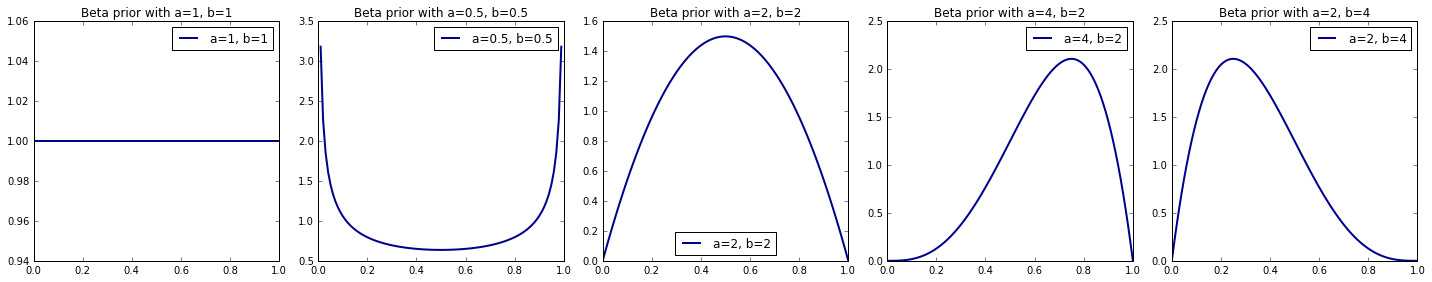

In [13]:
#A list of beta distribution shapes to try out
beta_shapes = [(1, 1), (0.5, 0.5), (2, 2), (4, 2), (2, 4)]
#Length of the list of shapes
n = len(beta_shapes)

#Plot all the beta pdfs in a row
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0
#Iterate through all the shapes
for a, b in beta_shapes:
    #Plot the beta pdf for a particular shape
    plot_beta_prior(a, b, 'darkblue', ax[ax_ind])
    #Increment the subplot index
    ax_ind += 1
    
plt.tight_layout()    
plt.show() 

The beta prior encodes commonsens values about how the likelihood affects the posterior. 

So, which beta prior encodes an appropriate belief about likability? If this is a difficult question to answer, let's look at the effect of the priors on the posterior (i.e. the likelihood of a particular "likelihood" given a set of observed ratings).

Pick some movies from your top 25 and experiment with combining their ratings information and different priors.

Each beta prior encodes a belief about likability. The effect of the priors on the posterior can be explored - this effectively gives the likelihood of a particular "likelihood" given a set of observed ratings.

The posterior distribution of a binomial likelihood and a beta prior is also a beta distribution in which the alpha parameter increased by the number of likes and the beta parameter is increased by the number of dislikes. 

French Twist (Gazon maudit) (1995): 1.0 (2.0/2.0)


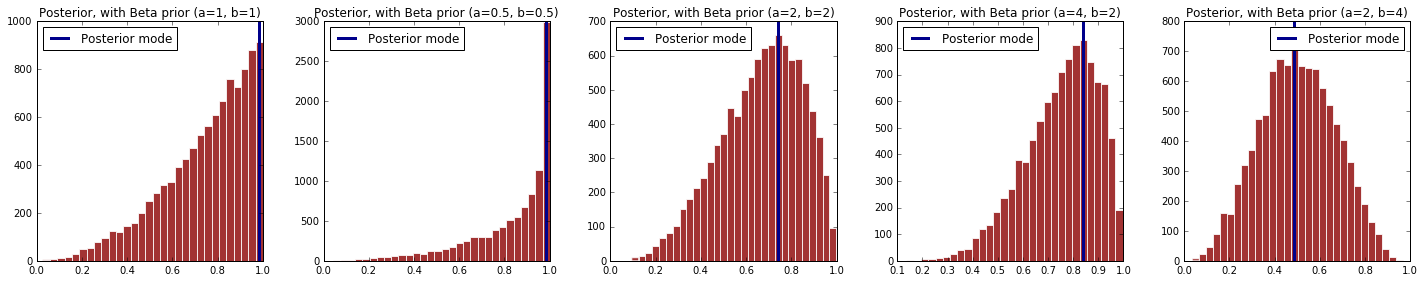

In [14]:
#Get the name of the first movie in the top 25 list
movie_name = top_25_movies[0][0]

#Get the ratings info for the first movie in the top 25 list
likes = top_25_movies[0][1]
total_ratings = top_25_movies[0][2]
likability = top_25_movies[0][3]

#Print movie info
print '{}: {} ({}/{})'.format(movie_name, likability, likes, total_ratings)

#Number of samples to use when approximating our posterior
n_samples = 10000

#Plot the posterior corresponding to each prior
fig, ax = plt.subplots(1, n, figsize=(20, 4))

#Start the index of the current subplot at 0
ax_ind = 0

#Iterate through all the shapes
for a, b in beta_shapes:   
    #Draw samples from the posterior corresponding to a particular beta prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate the posterior with a histogram of these samples
    ax[ax_ind].hist(post_samples, bins=30, color='darkred', alpha=0.8, edgecolor='white')
    #Find the approximate mode of the posterior
    mode = find_mode(post_samples, 30)
    #Plot the mode as a vertical line
    ax[ax_ind].axvline(x=mode, linewidth=3, label='Posterior mode', color = "darkblue")
    
    #Set title, legends etc
    ax[ax_ind].set_title('Posterior, with Beta prior (a={}, b={})'.format(a, b))
    ax[ax_ind].legend(loc='best')
    #Increment the subplot index
    ax_ind += 1

plt.tight_layout()
plt.show() 

So, how do we interpret the posterior? I.e. what is it telling us about the likability of a particular movie? 

How do we interpret the posterior mode? What does the mode tell us about the likability of a particular movie?

Do the posterior mode tell us the same thing about a movie's likability as the like-percentage? Which metric is more realistic or reasonable?

### Part 1(c): Recommendation based on ranking

- **Implementation:** Choose a reasonable beta prior, choose a reasonable statistic to compute from the posterior, and then build a list of top 25 movies that you would recommend to a new user based on your chosen posterior statistic.  

 
- **Analysis:** How does your top 25 movies compare with the list you obtained in part(a)? Which method of ranking is better?

 
- **Analysis:** So far, our estimates of the 'likability' for a movie was based on the ratings provided by all users. What can be the draw back of this method? How can we improve the recommender system for individual users (if you feel up to the challenge, implement your improved system and compare it to the one you built in the above)? 

### Step 5: Implement a ranking system that takes prior beliefs into account

Let's choose a reasonable beta prior and build a list of top 25 movies that you would recommend to a new user based on the posterior mode.

Why is this reasonable to do? There is an intuitive, layman's explanation for this as well as a formal statistical justification.

In [15]:
#Choose a beta prior that encodes a reasonable belief about likability 
a = 2 
b = 2

#Make a list of movie names and their ratings info
likability = []

#Iterate through all the movie names
for name in names_df['movie_name'].values:
    #Get ratings info for movie
    total_ratings, likes = movie_stats(movie_name=name)
    #Approximate the posterior given the ratings info and the prior
    post_samples = sample_posterior(a, b, likes, total_ratings, n_samples)
    #Approximate posterior mode
    mode = find_mode(post_samples, 30)
    #Add movie info to our list
    likability.append((name, likes, total_ratings, mode))

#Sort our list of movie info by like-percentage, in descending order
sorted_likability = sorted(likability, key=lambda t: t[3], reverse=True)  
#Get the movies with top 25 like-percentage
top_25_movies = sorted_likability[:25]

#Print results of ranking
print 'Top 25 Movies'
print '****************************'
for movie, likes, total_ratings, likable in top_25_movies:
    print movie, ':', likable, '({}/{})'.format(likes, total_ratings)

Top 25 Movies
****************************
Shawshank Redemption, The (1994) : 0.970720194991 (39.0/39.0)
Cool Hand Luke (1967) : 0.954754530498 (20.0/20.0)
Manchurian Candidate, The (1962) : 0.94571001153 (17.0/17.0)
Killing Fields, The (1984) : 0.94444665538 (14.0/14.0)
Godfather: Part II, The (1974) : 0.943654714252 (18.0/18.0)
Glory (1989) : 0.943390139519 (17.0/17.0)
Three Colors: Red (1994) : 0.938820227322 (12.0/12.0)
Wrong Trousers, The (1993) : 0.938598025623 (14.0/14.0)
Casablanca (1942) : 0.936771252975 (22.0/23.0)
Raiders of the Lost Ark (1981) : 0.935084020596 (47.0/49.0)
Vertigo (1958) : 0.91941960858 (22.0/23.0)
Thin Man, The (1934) : 0.916652721931 (8.0/8.0)
Alien (1979) : 0.912612089953 (28.0/30.0)
High Noon (1952) : 0.911223267822 (11.0/11.0)
Usual Suspects, The (1995) : 0.910643759256 (27.0/29.0)
Third Man, The (1949) : 0.903269329228 (9.0/9.0)
This Is Spinal Tap (1984) : 0.90294325152 (24.0/26.0)
Taxi Driver (1976) : 0.900684487283 (17.0/18.0)
Local Hero (1983) : 0.8

So while "Shawshank Redemption" is still highly ranked, "French Twist" no longer appears on our top 25. This at least seems more intuitive.

So, in what important ways is our top 25 list using the posterior mode different from our top 25 list using the like-percent? Which list is, generally speaking, more realistic and why?

---

## Problem 2: Predicting Urban Demographic Changes

### Part 2(a): Temporal patterns in urban demographics

In this problem you'll work with some neighborhood demographics of a region in Boston from the years 2000 to 2010. 

The data you need are in the files `dataset_1_year_2000.txt`, ..., `dataset_1_year_2010.txt`. The first two columns of each dataset contain the adjusted latitude and longitude of some randomly sampled houses. The last column contains economic status of a household: 

0: low-income, 

1: middle-class, 

2: high-income 

Due to the migration of people in and out of the city, the distribution of each economic group over this region changes over the years. The city of Boston estimates that in this region there is approximately a 25% yearly increase in high-income households; and a 25% decrease in the remaining population, with the decrease being roughly the same amongst both the middle class and lower income households.

Your task is to build a model for the city of Boston that is capable of predicting the economic status of a household based on its geographical location. Furthermore, your method of prediction must be accurate over time (through 2010 and beyond). 

**Hint:** look at data only from 2000, and consider using both Linear Discriminant Analysis (LDA) and Logistic Regression. Is there a reason one method would more suited than the other for this task?

**Hint:** how well do your two models do over the years? Is it possible to make use of the estimated yearly changes in proportions of the three demographic groups to improve the predictive accuracy of each models over the years? 

To help you visually interpret and assess the quality of your classifiers, we are providing you a function to visualize a set of data along with the decision boundaries of a classifier.

## Functions (necessary for the following calculations)

In [16]:
#--------  Scatter Plot
# A function that visualizes the data
# Input: 
#      x (variable on the x-axis)
#      y (variable on the y_axis)
#      df (panda data frame)
#      group (grouping variable, i.e., variable to plot)
#      col (vector of colors)
#      alpha (alpha value for colors)
#      size (size of the dots)
#      title (title of the plot)
#      marker (shape of the marker, default to 'o')
#      add_line (add a line plot)
#      linewidth (thinkness of the added line)
#      figsize (size of the figure)

def scatter_plot(x, y, df, group, col, alpha, size, title, marker='o', add_line=False, linewidth=1, figsize=(15, 5)):
    
    # Define plot
    fig = plt.figure(figsize = figsize)
    ax = plt.axes()

    # Extract unique categories
    cat = df[group].unique()

    # Loop trough categories
    for i in range(0, len(cat)) :
            ax.scatter(df[x][df[group] == cat[i]].values,
                       df[y][df[group] == cat[i]].values,
                       c=col[i], alpha=alpha, edgecolors="None", s=size,
                       label=cat[i],
                       marker=marker)
    # Add line plot
    if add_line:
            for i in range(0, len(cat)) :
                ax.plot(df[x][df[group] == cat[i]].values,
                           df[y][df[group] == cat[i]].values,
                           c=col[i], alpha=alpha, linewidth=linewidth)

    # Add legend, grid etc.
    ax.legend(loc=0, scatterpoints = 1) # Legend with just one dot
    ax.set_xlabel(x); ax.set_ylabel(y)
    ax.set_title(title)
    plt.grid()

In [17]:
#--------  plot_decision_boundary
# A function that visualizes the data and the decision boundaries
# Input: 
#      x (predictors)
#      y (labels)
#      poly_flag (a boolean parameter, fits quadratic model if true, otherwise linear)
#      title (title for plot)
#      ax (a set of axes to plot on)
# Returns: 
#      ax (axes with data and decision boundaries)

def plot_decision_boundary(x, y, model, poly_flag, title, ax):
    # Plot data
    ax.scatter(x[y == 0, 0], x[y == 0, 1], c='darkred', alpha = 0.4, edgecolors="None", s=20)
    ax.scatter(x[y == 1, 0], x[y == 1, 1], c='black', alpha = 0.4, edgecolors="None", s=20)
    ax.scatter(x[y == 2, 0], x[y == 2, 1], c='darkblue', alpha = 0.4, edgecolors="None", s=20)

    # Create mesh
    interval = np.arange(0,1,0.01)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_flag):
        quad_features = preprocessing.PolynomialFeatures(degree=2)
        xx = quad_features.fit_transform(xx)
    yy = model.predict(xx)    
    yy = yy.reshape((n, n))

    # Plot decision surface
    x1 = x1.reshape(n, n)
    x2 = x2.reshape(n, n)
    ax.contourf(x1, x2, yy, alpha=0.1, colors=["darkred", "black", "darkblue", "black", "white"])
    
    # Label axes, set title
    ax.set_title(title)
    ax.set_xlabel('Latitude')
    ax.set_ylabel('Longitude')
    ax.grid()
    
    return ax

## 1: Importing Data

The data consists of 11 dataframes over the years from 2000 to 2011 about the economic status of chicago citicens and their geografic location. The first step is to import the data and to create out of the 11 dataframes one concise dataframe to work with.

In [18]:
## Load the data
df_demo = None
years = range(2000, 2011)

# Loop trough all the different years
for i in range(0, len(years)):
    path = 'datasets/dataset_1_year_' + str(years[i]) + '.txt'
    csv = pd.read_csv(path, delimiter=' ', header=None, names=['longitude', 'latitude', 'econ_id'])
    csv['year'] = years[i]

    # The first iteration is special
    if df_demo is None:
        df_demo = csv
    else:
        df_demo = df_demo.append(csv)

print "first 5 entries of the overall dataframe:"
df_demo[0:5]

first 5 entries of the overall dataframe:


,longitude,latitude,econ_id,year
0,0.544328,0.624510,2.0,2000
1,0.594685,0.723913,2.0,2000
2,0.700180,0.782492,2.0,2000
3,0.601262,0.971812,2.0,2000
4,0.631995,0.748502,2.0,2000


The next step is to add the label variable of the economic status to the id variable: 

In [19]:
# Create income data frame with the corpesonding labels
df_econ = pd.DataFrame({'econ_id': [0, 1, 2],
                        'economic_status': ['low-income', 'middle-class', 'high-income']})
print "created helper table of the economic status:" 
df_econ

created helper table of the economic status:


,econ_id,economic_status
0,0,low-income
1,1,middle-class
2,2,high-income


In [20]:
df_econ

,econ_id,economic_status
0,0,low-income
1,1,middle-class
2,2,high-income


In [21]:
# Left join
df_demo = pd.merge(df_demo, df_econ, how='left', on=['econ_id', 'econ_id'])

# Show the data
print "first 5 entries of the new dataframe with the coresponding labels:"
df_demo[0:4]

first 5 entries of the new dataframe with the coresponding labels:


,longitude,latitude,econ_id,year,economic_status
0,0.544328,0.624510,2.0,2000,high-income
1,0.594685,0.723913,2.0,2000,high-income
2,0.700180,0.782492,2.0,2000,high-income
3,0.601262,0.971812,2.0,2000,high-income


## 2: Data exploration

The next step is exploring the data at hand.



In [22]:
# Select the year 2000 and 2010
df_demo_2000 = df_demo[df_demo['year'] == 2000]
df_demo_2010 = df_demo[df_demo['year'] == 2010]

# Print the number of rows
print "The demographic data of Chicago in the year 2000 consists of", df_demo_2000.shape[0], "observations."

The demographic data of Chicago in the year 2000 consists of 1000 observations.


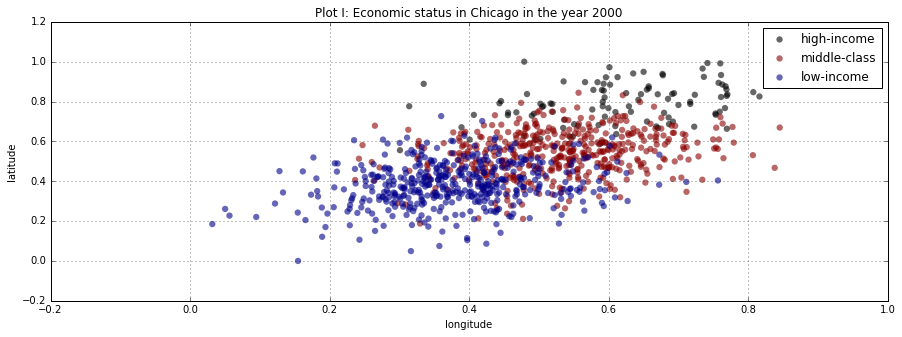

In [23]:
# Plot the data
col = ["black", "darkred", "darkblue"]
scatter_plot(x='longitude', y='latitude', df=df_demo_2000, group='economic_status',
             col=col, alpha=0.6, size=40, marker='o',
             title="Plot I: Economic status in Chicago in the year 2000")


The above plot shows that the classes apear to be normally distributed. In order to analyse the change over the years the data has to be aggregated over the years. The data for the three different clusters appears to have more or less the same variance with different means as the center. That could indicate, that LDA and QDA are going to outperform a logistic regression. 

In [24]:
# Aggregate
df_econ_years = pd.DataFrame(df_demo.groupby(['year', 'economic_status'], as_index=False)['longitude'].count())
df_econ_years.columns = ["year", "economic_status", "count"]

print "Aggregated economic status over the years:"
df_econ_years[0:4]

Aggregated economic status over the years:


,year,economic_status,count
0,2000,high-income,100
1,2000,low-income,450
2,2000,middle-class,450
3,2001,high-income,125


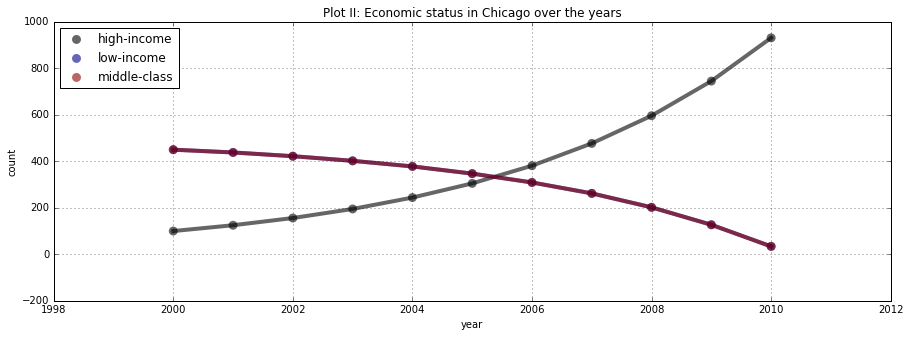

In [25]:
# Plot the data over the years
scatter_plot(x='year', y='count', df=df_econ_years, group='economic_status',
             col=["black", "darkblue", "darkred"], alpha=0.6, size=80,
             title="Plot II: Economic status in Chicago over the years", add_line=True,  linewidth=4)

The low-income and middle-class data follows the same trend, i.e., they are moving downwards. Furthermore, for every year they consist of the exactly same value, hence the overplotting. 


## 3: Preparing the data

In order to analyse the data three models are beeing fitted to the data. Those are:

1. Polynomial Logistic Regression (with L2 regularization)
2. Linear Discriminant Analysis (LDA)
3. Adjusted Linear Discriminant Analysis (LDA) with an estimation of the yearly changes

For model 1 and 2 the assumtin is, that there are the same numbers of houshold for each class and that the parameter stay stable over the years. This ceteris paribus assumtion is going to be relaxed later on. Nevertheless, the first model is beeing build on the year 2000. In order to be able to check for overfitting this 2000 dataset split into a training and a testing set. 

In [26]:
# Extracting the y and x variables
y = df_demo_2000['econ_id'].values
x = df_demo_2000[['longitude', 'latitude']].values

# Create testing and training set (70% Train, 30% Test)
np.random.seed(123) # Set random seed
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# Creat polynomial effects
poly = PolynomialFeatures(degree=2)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)


## 4.  Modelling

In [27]:
# Create logistic regression object
# c = 1/lamda --> Tuning parameter for regularization --> big c --> no regularization
np.random.seed(123) # Set random seed
logitm_cv = LogRegCV(Cs=200, cv=10, penalty="l2")
logitm_cv.fit(x_poly_train, y_train)


LogisticRegressionCV(Cs=200, class_weight=None, cv=10, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [28]:
# Calculate scores
cv_scores = logitm_cv.scores_[1.0]
mean_score = np.mean(cv_scores, axis=0)

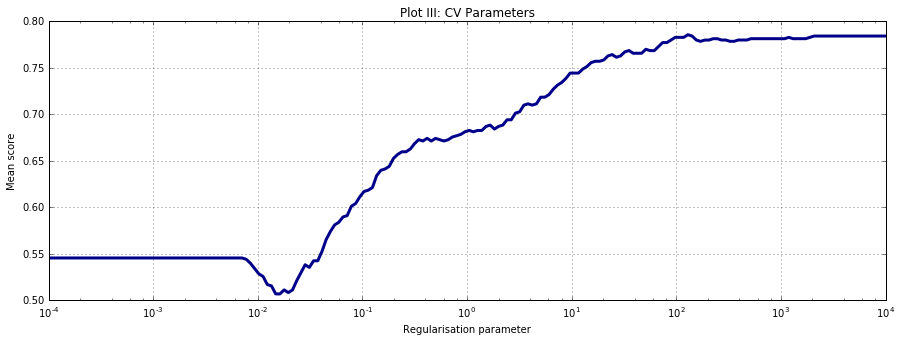

In [29]:
# Plotting
plt.figure(figsize=(15, 5))
plt.semilogx(logitm_cv.Cs_, mean_score, color='darkblue', linewidth=3)
plt.title('Plot III: CV Parameters')
plt.xlabel('Regularisation parameter'); plt.ylabel('Mean score')
plt.grid()

The above cross validation plot shows, that for a regularisation parameter around 0.01, the penalty leads to a random, i.e., 50/50 model. That means, that the model performes like chance. With a bigger regularisation parameter the penalty goes lower and the score gets better up to a point and then goes down again. This effect occurs because of overfitting. 

In [30]:
# Find the optimal c-value (regularisation parameter) 
print 'Optimal c-value: ', logitm_cv.C_[0]
print 'Mean score: ', max(mean_score)


Optimal c-value:  8.80488358164
Mean score:  0.785762306147


The optimal c-value is around 8.8 while that gives a mean score of 0.79 on the training data. Those values can now be used to build the logistic regression model.

#### Model building

In [31]:
# Build logistic model with the above c-value
logitm_model = LogReg(C = logitm_cv.C_[0], penalty = "l2")
logitm_model.fit(x_poly_train, y_train)

# Create LDA model
lda_model = LDA()
lda_model.fit(x_train, y_train)

# Create QDA model
qda_model = QDA()
qda_model.fit(x_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

## 5. Analysis:

After the model parameters have been determined, the next step is to make predictions on the testing set. 


In [32]:
# Predicting on the test set
y_pred_log = logitm_model.predict(x_poly_test)
y_pred_lda = lda_model.predict(x_test)
y_pred_qda = qda_model.predict(x_test)

In [33]:
print "Confusion matrix (logistic model):"
pd.crosstab(y_test, y_pred_log, rownames=['True'], colnames=['Predicted'], margins=True)

Confusion matrix (logistic model):


Predicted,0.0,1.0,2.0,All
True,,,,
0.0,124,17,0,141
1.0,36,93,3,132
2.0,0,8,19,27
All,160,118,22,300


In [34]:
print "Confusion matrix (lda):"
pd.crosstab(y_test, y_pred_lda, rownames=['True'], colnames=['Predicted'], margins=True)

Confusion matrix (lda):


Predicted,0.0,1.0,2.0,All
True,,,,
0.0,122,19,0,141
1.0,28,101,3,132
2.0,0,6,21,27
All,150,126,24,300


In [35]:
print "Confusion matrix (qda):"
pd.crosstab(y_test, y_pred_qda, rownames=['True'], colnames=['Predicted'], margins=True)

Confusion matrix (qda):


Predicted,0.0,1.0,2.0,All
True,,,,
0.0,122,19,0,141
1.0,28,101,3,132
2.0,0,6,21,27
All,150,126,24,300


The three confusion matrices show, that all the models at predicting the the high income housholds, they all have a bit more difficulties predicting the low and medium income housholds. The logistic model is a bit better in the low income class while the discriminant models outperform in the middle and low income section.
In order to visualize the decision boundaries the scores have to be calculated next. 

In [36]:
# Scoring
log_model_score = logitm_model.score(x_poly_test, y_test)
lda_model_score = lda_model.score(x_test, y_test)
qda_model_score = qda_model.score(x_test, y_test)

Chicago: Year 2000


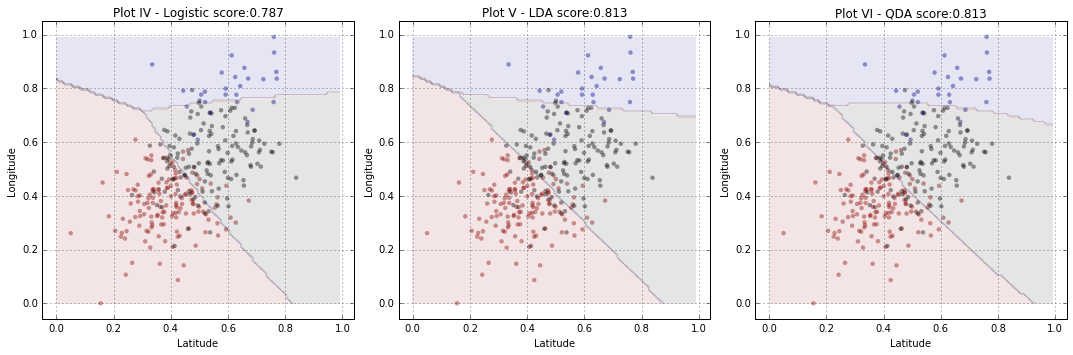

In [37]:
# Plot parameters
plt.figure(figsize=(10, 10))
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

# Ploting the decision boundaries
plot_decision_boundary(x_test, y_test, logitm_model, True, 'Plot IV - Logistic score:' + str(round(log_model_score, 3)), ax1)
plot_decision_boundary(x_test, y_test, lda_model, False, 'Plot V - LDA score:' + str(round(lda_model_score, 3)), ax2)
plot_decision_boundary(x_test, y_test, qda_model, False, 'Plot VI - QDA score:' + str(round(qda_model_score, 3)), ax3)
plt.tight_layout()

print "Chicago: Year 2000"

In the above plots show, that the LDA and QDA outperform the logistic regression. The LDA and QDA perform equally well. As could be seen in plot II, the proportion of the housholds is moving over the years. The next step is to check how the logistic model build on 2000 data on the 2010 data. 

In [38]:
# Extracting the y and x variables
y = df_demo_2010['econ_id'].values
x = df_demo_2010[['longitude', 'latitude']].values

# Create polynomial effects
poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x)

In [39]:
# Predicting on the test set
y_pred_log = logitm_model.predict(x_poly)
y_pred_lda = lda_model.predict(x)
y_pred_qda = qda_model.predict(x)

In [40]:
# Scoring
log_model_score = logitm_model.score(x_poly, y)
lda_model_score = lda_model.score(x, y)
qda_model_score = qda_model.score(x, y)

Chicago: Year 2010


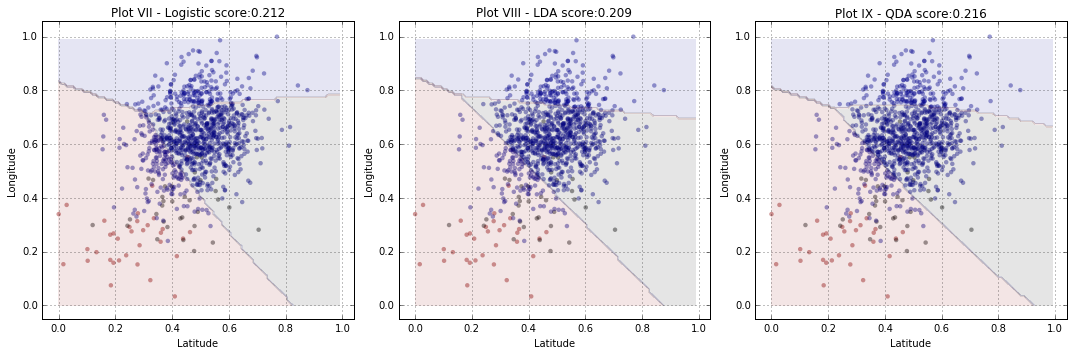

In [41]:
# Plot parameters
plt.figure(figsize=(10, 10))
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(15, 5))

# Ploting the decision boundaries
print "Chicago: Year 2010"
plot_decision_boundary(x, y, logitm_model, True, 'Plot VII - Logistic score:' + str(round(log_model_score, 3)), ax1)
plot_decision_boundary(x, y, lda_model, False, 'Plot VIII - LDA score:' + str(round(lda_model_score, 3)), ax2)
plot_decision_boundary(x, y, qda_model, False, 'Plot IX - QDA score:' + str(round(qda_model_score, 3)), ax3)
plt.tight_layout()

All the models trained on the 2000 data perform fairly bad at predicting the 2010 data. That is, a pure chance model would be better than using one of the above.

#### Predicting all the years

In [42]:
# Loop trough the model scores over all the years
score = []

for year in range(2000, 2011):
    df = df_demo[df_demo['year'] == year] 
    
    # Extracting the y and x variables
    y = df['econ_id'].values
    x = df[['longitude', 'latitude']].values

    # Create polynomial effects
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    
    # Scoring
    log_model_score = logitm_model.score(x_poly, y)
    lda_model_score = lda_model.score(x, y)
    qda_model_score = qda_model.score(x, y)

    score.append([year, log_model_score, lda_model_score, qda_model_score])

# Create np array
score = np.array(score)


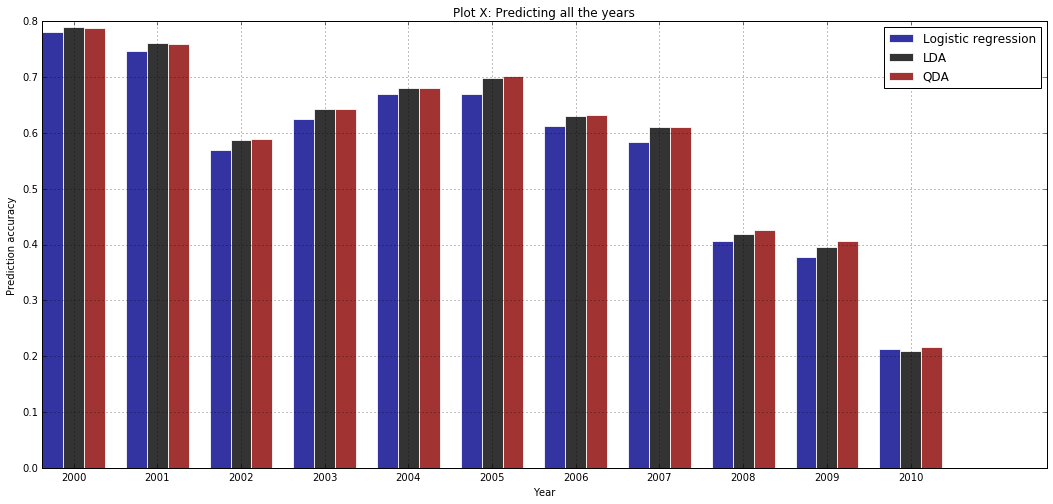

In [43]:
# Plot
plt.figure(figsize = (18, 8))
width = 0.25
years = np.arange(2000, 2011)

plt.bar(score[:,0], score[:, 1], width, color='darkblue', label='Logistic regression', edgecolor='white', alpha = 0.8)
plt.bar(score[:,0] + width, score[:, 2], width, color='black', label='LDA', edgecolor='white', alpha = 0.8)
plt.bar(score[:,0] + 2 * width, score[:, 3], width, color='darkred', label='QDA', edgecolor='white', alpha = 0.8)

plt.legend(loc='best')
plt.xlabel('Year')
plt.ylabel('Prediction accuracy')
plt.xticks(years + 1.5*width , years);
plt.grid()
plt.title('Plot X: Predicting all the years')
plt.show()


The above chart shows, that the prediction accuracy with the model build on the 2004 data varies over the years. However, after the year 2005 the accuracy drops more and more. This happens because the proportion of high-income houses increases (see plot II). The next step is to build a model that is factoring in the varing proportions.

## 6.Refining the model:

In [44]:
# Starting even distribution:
start = np.array([1/3., 1/3., 1/3.])
multi = np.array([1, 1, 1.25])
sampling_probability = [start * multi**i / np.sum(start * multi**i) for i in range(0, 11)]

In [45]:
# Loop trough the model scores over all the years
score = []
lda_model_prop = lda_model
qda_model_prop = qda_model

for year in range(2000, 2011):
    df = df_demo[df_demo['year'] == year] 
    
    # Extracting the y and x variables
    y = df['econ_id'].values
    x = df[['longitude', 'latitude']].values

    # Create polynomial effects
    poly = PolynomialFeatures(degree=2)
    x_poly = poly.fit_transform(x)
    
    # Update the coefficients
    sp = np.array(sampling_probability[year - 2000]).reshape(-1, 1)
    lda_model_prop.coef_ = lda_model_prop.coef_ + np.log(sp)
    qda_model_prop.priors_ = sampling_probability[year - 2000]
 
    # Scoring
    log_model_score = logitm_model.score(x_poly, y)
    lda_model_score = lda_model.score(x, y)
    lda_model_prop_score = lda_model_prop.score(x, y)
    qda_model_score = qda_model.score(x, y)
    qda_model_prop_score = qda_model_prop.score(x, y)

    score.append([year, log_model_score, lda_model_score, lda_model_prop_score, qda_model_score, qda_model_prop_score])

# Create np array
score = np.array(score)


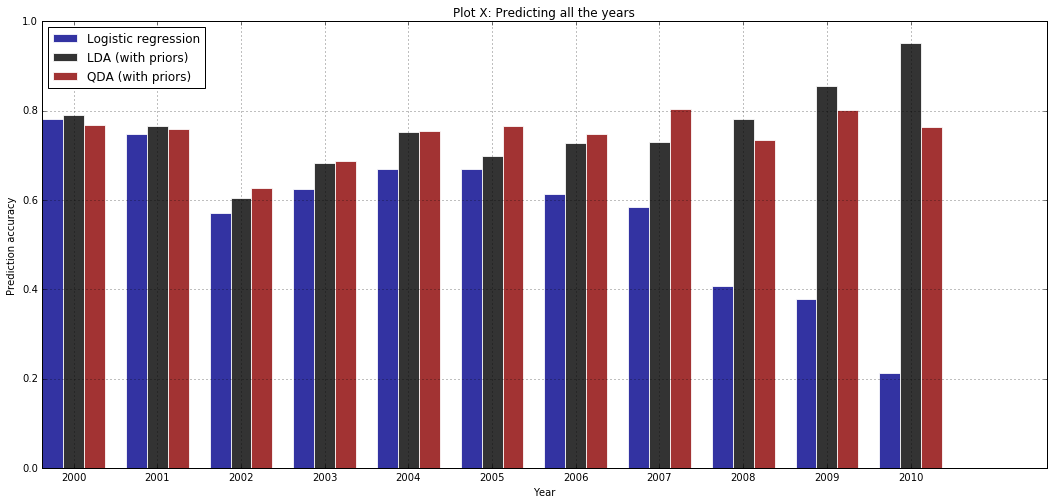

In [46]:
# Plot
plt.figure(figsize = (18, 8))
width = 0.25
years = np.arange(2000, 2011)

plt.bar(score[:,0], score[:, 1], width, color='darkblue', label='Logistic regression', edgecolor='white', alpha = 0.8)
plt.bar(score[:,0] + width, score[:, 3], width, color='black', label='LDA (with priors)', edgecolor='white', alpha = 0.8)
plt.bar(score[:,0] + 2 * width, score[:, 5], width, color='darkred', label='QDA (with priors)', edgecolor='white', alpha = 0.8)

plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Prediction accuracy')
plt.xticks(years + 1.5 * width , years);
plt.grid()
plt.title('Plot X: Predicting all the years')
plt.show()


The above plot shows, that using priors increases the predictive capabiltiy of the LDA and QDA models significantly. For the prediction in the year 2010 there appears to be a overfitting of the QDA model going on. The best model for predicting the income of the residence is the LDA model with priors. The change of the decision boundary of the LDA model can be further visualized. 

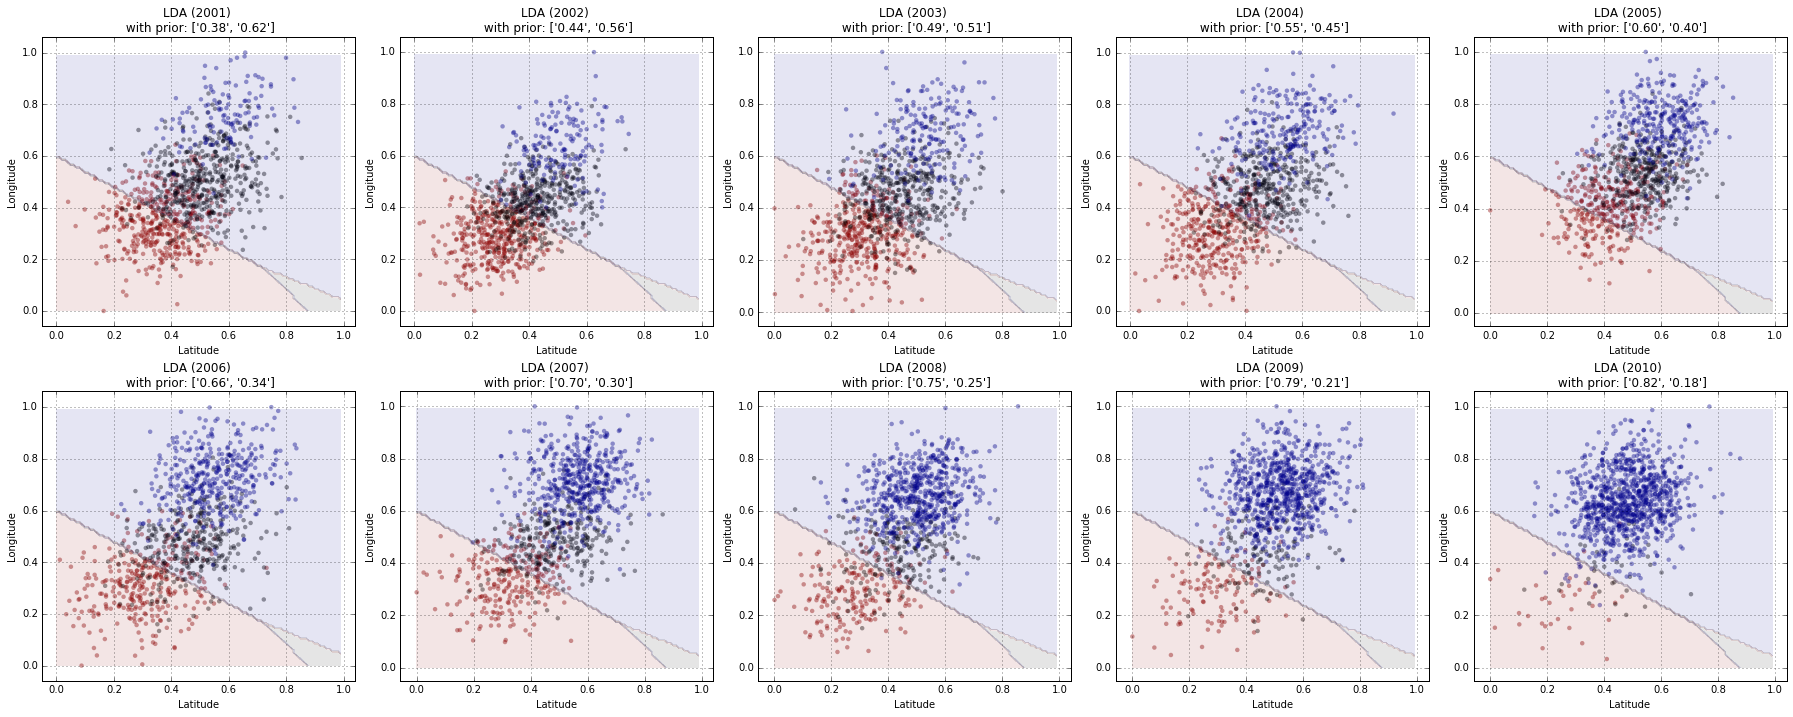

In [47]:
# Plot parameters
fig, axes = plt.subplots(2,5, figsize=(25,10))
axes = axes.flatten()

for year in range(2001, 2011):
    df = df_demo[df_demo['year'] == year] 
     
    # Extracting the y and x variables
    y = df['econ_id'].values
    x = df[['longitude', 'latitude']].values
    
    # Use the priors 
    lda_model_prop = lda_model
    sp = [sampling_probability[year-2000][-1], np.sum(sampling_probability[year-2000][:2])]
    lda_model_prop.coef_ = lda_model_prop.coef_ + np.log(sp)

    title = 'LDA ('+ str(year) +') \n with prior: ' + str(["%.2f" % v for v in sp])
    plot_decision_boundary(x, y, lda_model_prop, False, title, axes[year-2001])

fig.tight_layout()
plt.show()

The above plot shows, that using priors changes the decision boundary of the LDA model in such a way, that it is able to make reasonable predictions for all the years. 

### Part 2(b): Geographic patterns in urban demographics

In `dataset_2.txt` and `dataset_3.txt` you have the demographic information for a random sample of houses in two regions in Cambridge. There are only two economic brackets for the households in these datasets: 

0: low-income or middle-class, 

1 - high-income. 

For each region, recommend a classification model, chosen from all the ones you have learned, that is most appropriate for classifying the demographics of households in the region.

**Hint:** Support your answers with both numerical and visual analysis.

## Region 1

### Import and prepare data

In [48]:
## Load the data
df_1 = pd.read_csv('datasets/dataset_2.txt', header=None, sep = ' ', names=['longitude', 'latitude', 'econ_id'])

print "first 5 entries of the overall dataframe:"
df_1[0:4]

first 5 entries of the overall dataframe:


,longitude,latitude,econ_id
0,0.542866,0.433326,1.0
1,0.512297,0.491020,1.0
2,0.620624,0.303222,1.0
3,0.620553,0.478634,1.0


In [49]:
# Create income data frame with the corpesonding labels
df_econ = pd.DataFrame({'econ_id': [0, 1],
                        'economic_status': ['low-medium-income', 'high-income']})
print "created helper table of the economic status:" 
df_econ

created helper table of the economic status:


,econ_id,economic_status
0,0,low-medium-income
1,1,high-income


In [50]:
# Left join
df_1 = pd.merge(df_1, df_econ, how='left', on=['econ_id', 'econ_id'])

# Show the data
print "first 5 entries of the new dataframe with the coresponding labels:"
df_demo[0:4]

first 5 entries of the new dataframe with the coresponding labels:


,longitude,latitude,econ_id,year,economic_status
0,0.544328,0.624510,2.0,2000,high-income
1,0.594685,0.723913,2.0,2000,high-income
2,0.700180,0.782492,2.0,2000,high-income
3,0.601262,0.971812,2.0,2000,high-income


### Data exploration

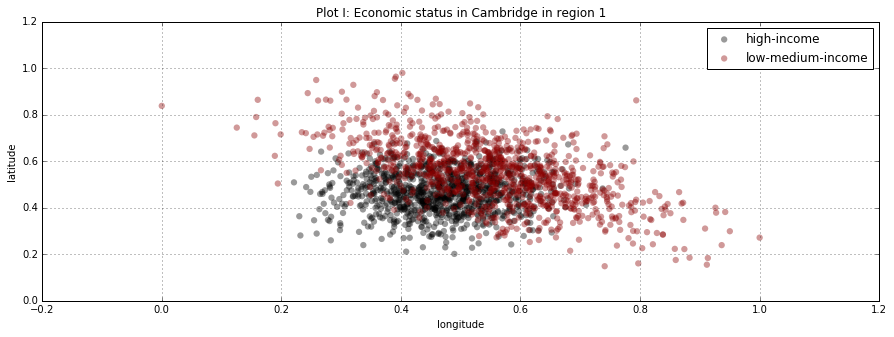

In [51]:
# Scatterplot
col = ["black", "darkred"]
scatter_plot(x='longitude', y='latitude', df=df_1, group='economic_status',
             col=col, alpha=0.4, size=40, marker='o',
             title="Plot I: Economic status in Cambridge in region 1")

The above plot show that the richer housholds (black) life more in the lower left corner while the medium and low income housholds (red) take the upper right region. There is also quit some overlap of the data of region 1.

### Preparing the data

In [52]:
# Extracting the y and x variables
y = df_1['econ_id'].values
x = df_1[['longitude', 'latitude']].values

# Create testing and training set (70% Train, 30% Test)
np.random.seed(123) # Set random seed
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


The best model is chosen trough using 6 different competing model. The best model is choosen trough its performance. The following models are beeing tested:


1. K-nearest neighbor (KNN, k=10)

2. K-nearest neighbor (KNN, k=100)

3. Logistic regression (with main effects)

4. Logistic regression (with ’quadratic’ effects)

5. Linear Discriminant Analysis (LDA)

6. Quadratic Discriminant Analysis (QDA)



### Modeling

In [53]:
# KNN 10
knn_model_10 = KNN(n_neighbors=10)
knn_model_10.fit(x_train, y_train)
knn_model_score_10 = knn_model_10.score(x_test, y_test)

# KNN 10
knn_model_100 = KNN(n_neighbors=100)
knn_model_100.fit(x_train, y_train)
knn_model_score_100 = knn_model_100.score(x_test, y_test)

# Logistic regression
log_model = LogReg()
log_model.fit(x_train, y_train)  
log_model_score = log_model.score(x_test, y_test)

# Logistic regression with quadratic effects
poly = PolynomialFeatures(degree=2)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)
log_model_quad = LogReg()
log_model_quad.fit(x_poly_train, y_train)
log_model_quad_score = log_model_quad.score(x_poly_test, y_test)

# LDA
lda_model = LDA()
lda_model.fit(x_train, y_train)
lda_model_score = lda_model.score(x_test, y_test)

# QDA 
qda_model = QDA()
qda_model.fit(x_train, y_train)
qda_model_score = qda_model.score(x_test, y_test)

### Visualizing

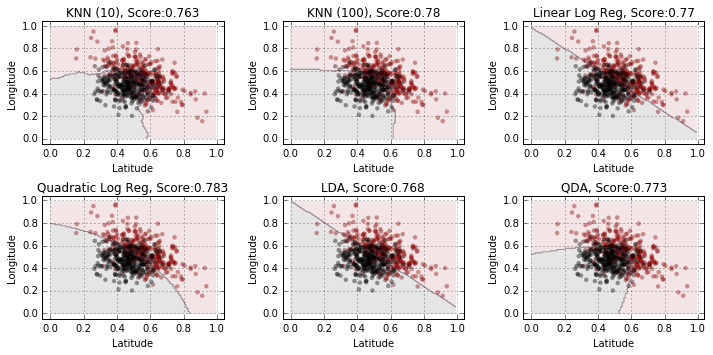

In [54]:
# Plot parameters
plt.figure(figsize=(10, 10))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))

# Ploting the decision boundaries
plot_decision_boundary(x_test, y_test, knn_model_10, False, 'KNN (10), Score:' + str(round(knn_model_score_10, 3)), ax1)
plot_decision_boundary(x_test, y_test, knn_model_100, False, 'KNN (100), Score:' + str(round(knn_model_score_100, 3)), ax2)
plot_decision_boundary(x_test, y_test, log_model, False, 'Linear Log Reg, Score:' + str(round(log_model_score, 3)), ax3)
plot_decision_boundary(x_test, y_test, log_model_quad, True, 'Quadratic Log Reg, Score:' + str(round(log_model_quad_score, 3)), ax4)
plot_decision_boundary(x_test, y_test, lda_model, False, 'LDA, Score:' + str(round(lda_model_score, 3)), ax5)
plot_decision_boundary(x_test, y_test, qda_model, False, 'QDA, Score:' + str(round(qda_model_score, 3)), ax6)
plt.tight_layout()

The above plots show that the best performance is reached with the quadratic logistic regression. It appears that the LDA and QDA both suffer under their normality assumptions. The KNN (k=10) apperears to overfit the training data while the KNN (k=100) does a much better job and is almost as good as the QDA model. Because of the computational strain of the knn and the better performance of the quadratic logistic regression, the latter is the prefered method for classifing housholds in region 1.

## Region 2

### Import and prepare data

In [55]:
## Load the data
df_2 = pd.read_csv('datasets/dataset_3.txt', header=None, sep = ' ', names=['longitude', 'latitude', 'econ_id'])

print "first 5 entries of the overall dataframe:"
df_2[0:4]

first 5 entries of the overall dataframe:


,longitude,latitude,econ_id
0,0.126227,0.846415,1.0
1,0.115902,0.886631,1.0
2,0.139295,0.794580,1.0
3,0.123552,0.832449,1.0


In [56]:
# Left join
df_2 = pd.merge(df_2, df_econ, how='left', on=['econ_id', 'econ_id'])

# Show the data
print "first 5 entries of the new dataframe with the coresponding labels:"
df_demo[0:4]

first 5 entries of the new dataframe with the coresponding labels:


,longitude,latitude,econ_id,year,economic_status
0,0.544328,0.624510,2.0,2000,high-income
1,0.594685,0.723913,2.0,2000,high-income
2,0.700180,0.782492,2.0,2000,high-income
3,0.601262,0.971812,2.0,2000,high-income


### Data exploration

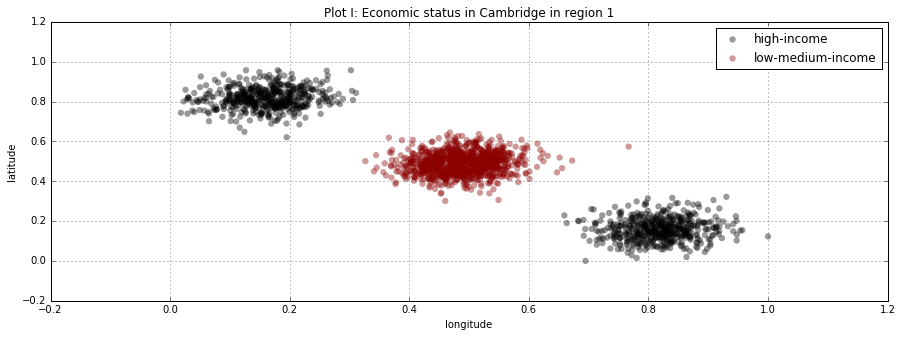

In [57]:
col = ["black", "darkred"]
scatter_plot(x='longitude', y='latitude', df=df_2, group='economic_status',
             col=col, alpha=0.4, size=40, marker='o',
             title="Plot I: Economic status in Cambridge in region 1")

The above plot shows that there are 3 very distinct income clusters present in region 2. Two of them consist of high-income housholds (black) while 1 consists of the low to medium income housholds (red).

### Preparing the data

In [58]:
# Extracting the y and x variables
y = df_2['econ_id'].values
x = df_2[['longitude', 'latitude']].values

# Create testing and training set (70% Train, 30% Test)
np.random.seed(123) # Set random seed
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)


### Modeling

In [59]:
# KNN 10
knn_model_10 = KNN(n_neighbors=10)
knn_model_10.fit(x_train, y_train)
knn_model_score_10 = knn_model_10.score(x_test, y_test)

# KNN 10
knn_model_100 = KNN(n_neighbors=100)
knn_model_100.fit(x_train, y_train)
knn_model_score_100 = knn_model_100.score(x_test, y_test)

# Logistic regression
log_model = LogReg()
log_model.fit(x_train, y_train)  
log_model_score = log_model.score(x_test, y_test)

# Logistic regression with quadratic effects
poly = PolynomialFeatures(degree=2)
x_poly_train = poly.fit_transform(x_train)
x_poly_test = poly.fit_transform(x_test)
log_model_quad = LogReg()
log_model_quad.fit(x_poly_train, y_train)
log_model_quad_score = log_model_quad.score(x_poly_test, y_test)

# LDA
lda_model = LDA()
lda_model.fit(x_train, y_train)
lda_model_score = lda_model.score(x_test, y_test)

# QDA 
qda_model = QDA()
qda_model.fit(x_train, y_train)
qda_model_score = qda_model.score(x_test, y_test)

### Visualizing

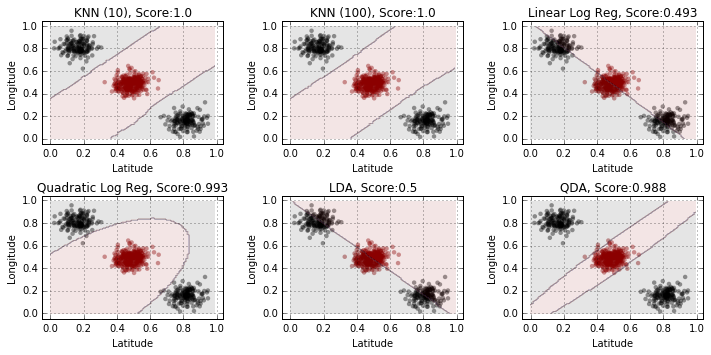

In [60]:
# Plot parameters
plt.figure(figsize=(10, 10))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 5))

# Ploting the decision boundaries
plot_decision_boundary(x_test, y_test, knn_model_10, False, 'KNN (10), Score:' + str(round(knn_model_score_10, 3)), ax1)
plot_decision_boundary(x_test, y_test, knn_model_100, False, 'KNN (100), Score:' + str(round(knn_model_score_100, 3)), ax2)
plot_decision_boundary(x_test, y_test, log_model, False, 'Linear Log Reg, Score:' + str(round(log_model_score, 3)), ax3)
plot_decision_boundary(x_test, y_test, log_model_quad, True, 'Quadratic Log Reg, Score:' + str(round(log_model_quad_score, 3)), ax4)
plot_decision_boundary(x_test, y_test, lda_model, False, 'LDA, Score:' + str(round(lda_model_score, 3)), ax5)
plot_decision_boundary(x_test, y_test, qda_model, False, 'QDA, Score:' + str(round(qda_model_score, 3)), ax6)
plt.tight_layout()

The above plots show, that the K-nearest neighbours perfom the best with a perfect score of 1. This result is followed by the quadratic logistic regression. The QDA also performes very well. Only the linear logisitc regression and the LDA don't perform better than chance with values around 50/50. This is because they have to split the data linearly and are not able to capture the non-linear behavior of the data. Because of the perfect score KNN is the prefered choice for clustering housholds in region 2. However, should the overall dataset be to large for KNN to perform well, the quadratic logistic regression would also be a feasible option.

---

## Challenge Problem: Regularization

We have seen ways to include different forms of regularizations in Linear regression and Logistic regression, in order to avoid overfitting. We will now explore ways to incorporate regularization within the discriminant analysis framework.

- When we have a small training sample, we end up with poor estimates of the class proportions $\pi_i$ and covariance matrices $\Sigma$. How can we regularize these quantities to improve the quality of the fitted model?


- We have seen that different assumptions on the covariance matrix results in either a linear or quadratic decision boundary. While the former may yield poor prediction accuracy, the latter could lead to over-fitting. Can you think of a suitable way to regularize the covariance to have an intermediate fit?

The solutions that you suggest must include a parameter that allows us to control the amount of regularization.

Be detailed in your explanation and support your reasoning fully. You do not, however, need to implement any of these solutions.

## Solution:
*(The here described solution follows the approach chosen by the sklearn QDA package.)*

When we have a small training sample, we end up with poor estimates of the class proportions πiπi and covariance matrices ΣΣ. In order to solve this problem a regularization parameter for LDA and QDA has to be introduced. In order to do this lets first look at the assumtions and functions of the two discriminant analysis frameworks (LDA and QDA). They both assume that the observed classes come from a normal distribution. The two function can be described by the following statements:

**Linear discriminant analysis (LDA):** $δk(x) = x^T Σ^{-1}μ_k − \frac{1}{2}μ_k^T Σ^{-1}μ_k + log (π_k)$

**quadratic discriminant analysis (QDA):** $δk(x) = −\frac{1}{2}x^TΣ_k^{−1}x+x^TΣ_k^{−1}μ_k−\frac{1}{2}μ_k^TΣ_k^{-1}μ_k−\frac{1}{2}log|Σ_k|+log(π_k)$

Assuming that there are $K$ classes and $p$ predictors, an LDA has $Kp$ parameters compared to the QDA model which has a different covariance matrix for each class and consequently has $Kp(p+1)/2$ parameters. Those covariance matrises of the LDA and QDA can be regularized, i.e., reducing the variance of the estimate (but introducing bias). 

In order to do this a classifier that lies between an LDA and QDA model can be used. That can be done by using a weighted combination of the two covariance matrix from LDA and QDA. 

**Regularization: ** $ \hat{\Sigma} = (1-\lambda)\Sigma_k + \lambda\Sigma $

Where $\Sigma$ is the shared covariance estimated from LDA and $\Sigma_k$ is the class specific covariance. Looking at the formula shows that setting $\lambda$ to zero the covariance of the LDA is set equal to the covariance of the QDA. On the other hand, when $\lambda $ apporaches 1, the covariance is equal to the one from the LDA. Any value between zero and one represents threfore a combination of the two models. 


## Implementation:

As mentioned above, the sklearn packages has an implementation of the above approach. This can be simulated on the region 1 dataset.


In [61]:
# Extract data
x = df_1[['latitude', 'longitude']]
y = df_1['econ_id']

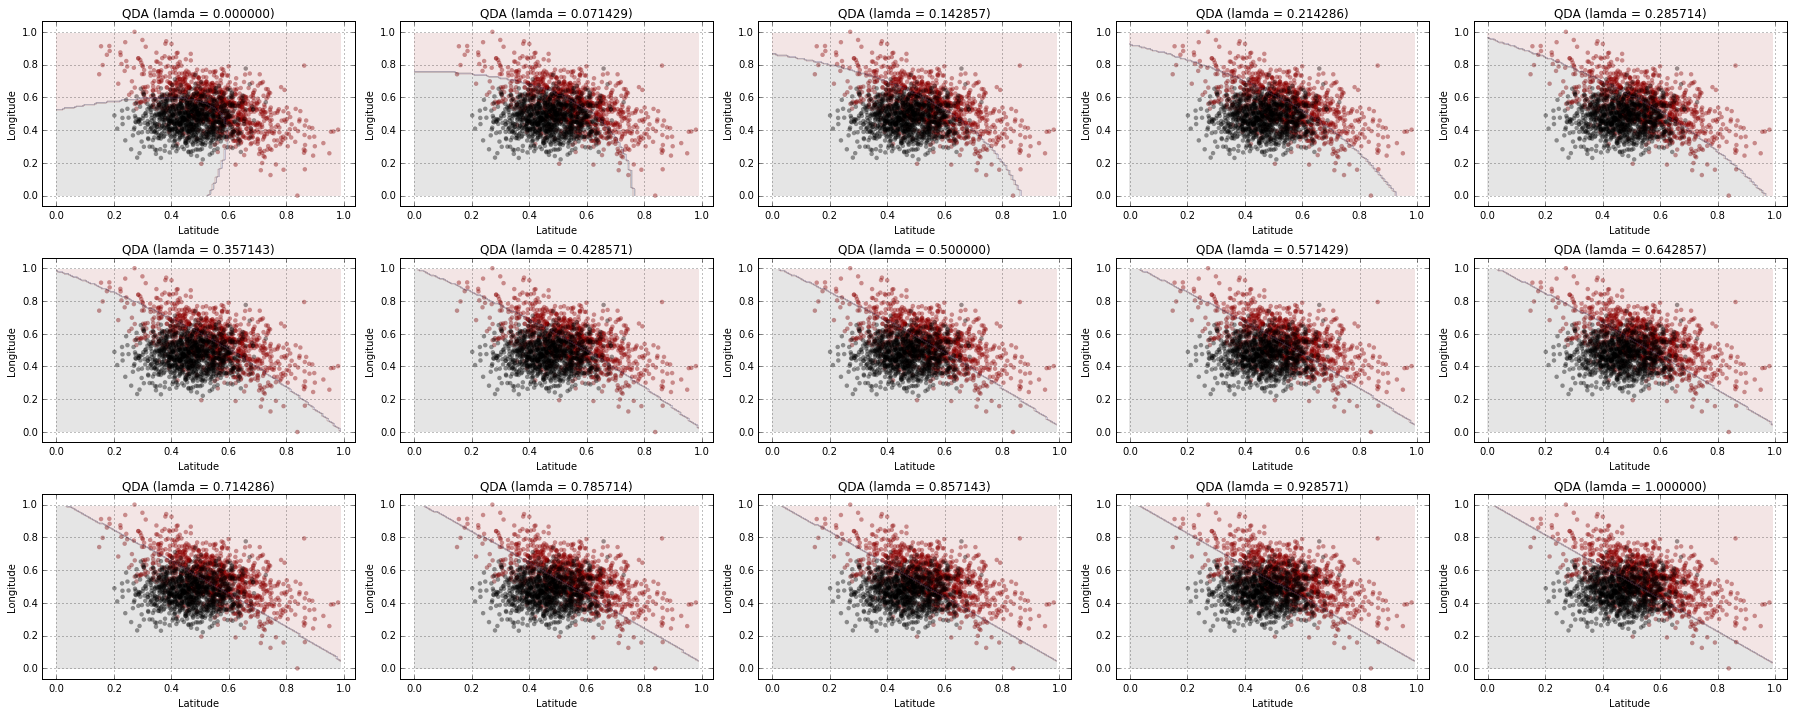

In [65]:
# Moving the lambda parameter from 0 to 1
lambdas = np.linspace(0, 1, 15)
fig, axes = plt.subplots(3, 5, figsize=(25, 10))
axes = axes.flatten()

# Looping trough different lampdas
index = 0
for i in lambdas:
    qda_reg = QDA(reg_param = i)
    qda_reg.fit(x, y)

    plot_decision_boundary(x.values, y.values, qda_reg, 
                           False, 'QDA (lamda = %f)' % i, 
                           axes[index])
    index += 1
fig.tight_layout()
plt.show()

The above plots show how the regulariztation parameter moves the decision boundary from the QDA model (upper left) to LDA model (bottom right). That means the covariance matrix is either moved into the direction of the LDA or the QDA. This is exactly what is described in a more formal way in the solution above. 